# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
from datetime import datetime
import os
import pathlib
import matplotlib.pyplot as plt

# 1. Load Data

In [2]:
# Create a list to add csv files as df
Bldg = []

# Read all building data and append to list
for path in pathlib.Path("../Data/microclimate_model/Combined/dataset1").iterdir():
        if path.is_file():
            current_file = pd.read_csv(path)
            current_file = current_file.drop(columns=['Unnamed: 0'])
            Bldg.append(current_file)
    

## 1.1 Preprocessing 

1. Adding Month, Hour, and Minute to data
2. Removing hours out of ENVI-met accuracy range (after 9 pm)
3. Add CHWTON/SQFT to columns using condition area for each building taken from
    https://fdm-apps.asu.edu/UFRM/FDS/FacilityData.aspx

In [3]:
# Create Month, Hour, and Minute column for all dataframes in list
for i in range(len(Bldg)):
    Bldg[i].Date_Time = pd.to_datetime(Bldg[i].Date_Time)
    Bldg[i]['Month_num'] = Bldg[i].Date_Time.dt.month
    Bldg[i]['Hour_num'] = Bldg[i].Date_Time.dt.hour
    Bldg[i]['Minute_num'] = Bldg[i].Date_Time.dt.minute

# Remove data after 9pm
for i in range(len(Bldg)):
    Bldg[i] = Bldg[i][(Bldg[i]['Hour_num'] <= 20) & (Bldg[i]['Hour_num'] > 0)]

# Add Column: CHWTON/Condition Area (SqFt) or ['CHWTON/SQFT']
cond_area = {'Noble Library':88658,'Biodesign B':132215,'Biodesign C':145410,
             'Biodesign A':133016,'Psychology':69864,'Goldwater':165237,'Schwada COB':99857,
             'ISTB 2':41404,'Bulldog Hall':68067,'ISTB 4':231646,'Psychology North':43034}
for i in range(len(Bldg)):
    if Bldg[i]['bldgname'][0] in cond_area:
        Bldg[i]['CHWTON/SQFT'] = Bldg[i]['CHWTON'] / cond_area[Bldg[i]['bldgname'][0]]

<ipython-input-3-5ea8a359b387>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bldg[i]['CHWTON/SQFT'] = Bldg[i]['CHWTON'] / cond_area[Bldg[i]['bldgname'][0]]


# 2. Single Building

## 2.1 Select Building

In [6]:
# Ask user to select building
for i in range(len(Bldg)):
    print(i, Bldg[i]['bldgname'][0])

bldgnum = int(input("Enter the number of the building from the list above: "))

Bldg[bldgnum].head()

0 Noble Library
1 Biodesign B
2 Biodesign C
3 Biodesign A
4 Psychology
5 Goldwater
6 Schwada COB
7 ISTB 2
8 Bulldog Hall
9 ISTB 4
10 Psychology North


Enter the number of the building from the list above:  3


,bldgname,Date,Time,Air Temp,Rel Hum,KW,CHWTON,HTmmBTU,Date_Time,Month_num,Hour_num,Minute_num,CHWTON/SQFT
0,Biodesign A,2018-05-16,05:00,24.040925,20.616757,491.14,174.63,0.32,2018-05-16 05:00:00,5,5,0,0.001313
1,Biodesign A,2018-05-16,05:15,24.220021,23.379832,497.77,151.36,0.35,2018-05-16 05:15:00,5,5,15,0.001138
2,Biodesign A,2018-05-16,05:30,24.054303,23.070921,516.80,184.04,0.36,2018-05-16 05:30:00,5,5,30,0.001384
3,Biodesign A,2018-05-16,05:45,23.935568,23.126250,533.50,181.98,0.31,2018-05-16 05:45:00,5,5,45,0.001368
4,Biodesign A,2018-05-16,06:00,23.808253,23.394283,516.03,177.49,0.32,2018-05-16 06:00:00,5,6,0,0.001334


## 2.2 EDA

### 2.2.1 Boxplots

0 bldgname
1 Date
2 Time
3 Air Temp
4 Rel Hum
5 KW
6 CHWTON
7 HTmmBTU
8 Date_Time
9 Month_num
10 Hour_num
11 Minute_num
12 CHWTON/SQFT


Enter the number of the following data columns to graph boxplot:  6



 Biodesign A


<AxesSubplot:title={'center':'CHWTON'}, xlabel='Hour_num'>

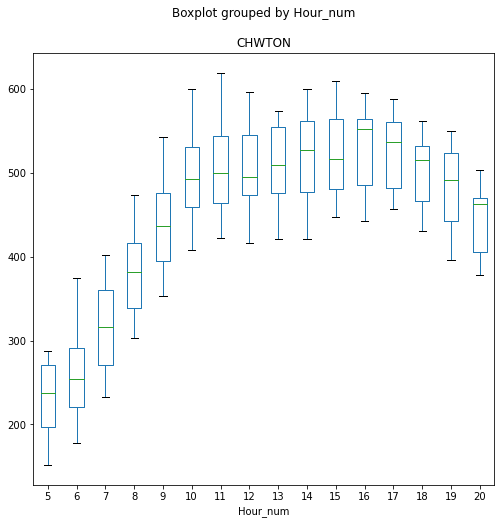

In [7]:
# Show df columns to select for boxplot
x = Bldg[bldgnum].columns
for i in range(len(x)):
    print(i, x[i])
# Get column name from user
colname = int(input("Enter the number of the following data columns to graph boxplot: "))
# Plot
print('\n',Bldg[bldgnum]['bldgname'][0])
Bldg[bldgnum].boxplot(by='Hour_num', column=x[colname], grid = False, figsize = (8,8))

### 2.2.2 Time Series

Month available:<br>
May: 16, 23 <br>
June: 7, 8, 20, 21, 25<br>
August: 3<br>
September: 11, 29<br>

Enter month number:  5



 1 day(s) found in May 

0 bldgname
1 Date
2 Time
3 Air Temp
4 Rel Hum
5 KW
6 CHWTON
7 HTmmBTU
8 Date_Time
9 Month_num
10 Hour_num
11 Minute_num
12 CHWTON/SQFT


Enter y-axis from column list above:  5


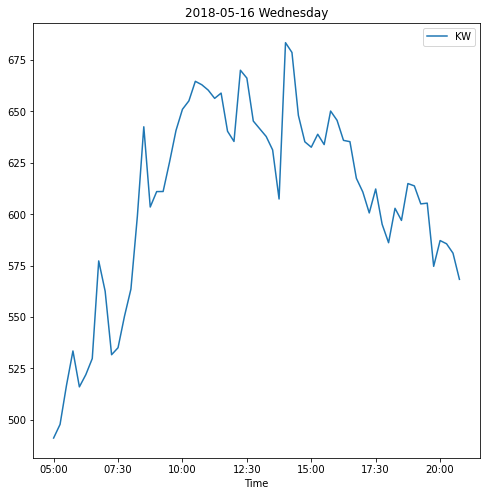

In [9]:
import datetime
# Get month number for plotting
m_num = int(input("Enter month number: "))
# Convert to datetime to get month name
datetime_object = datetime.datetime.strptime(str(m_num), "%m")
m_name = datetime_object.strftime("%b")

# Plot only if entered month is in data
if m_num in Bldg[bldgnum]['Month_num'].unique():
    from datetime import datetime
    # Assign new df for chosen month
    plotdf = pd.DataFrame(Bldg[bldgnum][(Bldg[bldgnum]['Month_num'] == m_num)])
    # Show number of days found in chosen month
    x = plotdf['Date'].unique()
    print("\n", len(x), "day(s) found in", m_name, "\n")
    # Show all columns to select y-axis for plotting
    cols = plotdf.columns
    for i in range(len(cols)):
        print(i, cols[i])
    # Get y-axis for plotting
    y_ax = int(input('Enter y-axis from column list above: '))
    y_ax = cols[y_ax]
    for i in range(len(x)):
        datetime_object = datetime.strptime(x[i], '%Y-%m-%d')
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        d = days[datetime_object.weekday()]
        plotdf1 = plotdf[(plotdf['Date']==x[i])]
        plotdf1.plot(x = 'Time', y = y_ax, grid = False, figsize = (8,8), title = x[i] + ' ' + d)
else:
    print("Month number not in data")

### 2.2.3 Correlation Matrix

<AxesSubplot:>

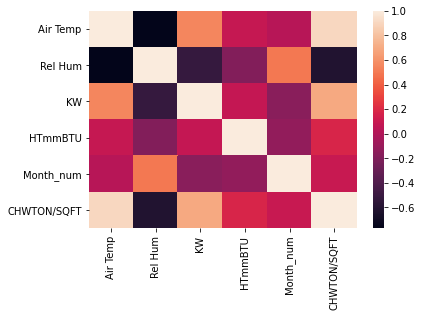

In [10]:
corr_pd = pd.DataFrame(Bldg[bldgnum][['Time','Air Temp','Rel Hum','KW','HTmmBTU','Month_num', 'CHWTON/SQFT']])
corrMatrix = corr_pd.corr()
sns.heatmap(corrMatrix)


## 2.3 Random Forest without tuning

In [11]:
# drop na values if in dataframe
if (Bldg[bldgnum].isnull().values.any() == True):
    Bldg[bldgnum] = Bldg[bldgnum].dropna()
    
# split data into X and y
X = Bldg[bldgnum].drop(columns=['CHWTON/SQFT','Month_num', 'Date', 'Time','bldgname','HTmmBTU', 'Date_Time', 'CHWTON', 'KW', 'Minute_num'])
y = Bldg[bldgnum]['CHWTON/SQFT']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Set up model. Number of trees 100
base_RF = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Train data
base_RF.fit(X_train, y_train)

# Get prediction
y_pred = base_RF.predict(X_test)
ModelPred = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
ModelPred = ModelPred.sort_index()
print(ModelPred)

score = base_RF.score(X_test, y_test)
rf_score = pd.DataFrame({"bldgname": Bldg[bldgnum]['bldgname'].unique()[0], "test score (on 20% of data)": [score]})
rf_score

       Actual  Predicted
2    0.001384   0.001337
9    0.002013   0.001765
10   0.001964   0.001882
13   0.002378   0.001945
14   0.002495   0.002066
..        ...        ...
573  0.003790   0.003807
582  0.003698   0.003611
583  0.003658   0.003636
587  0.003709   0.003672
592  0.003605   0.003468

[103 rows x 2 columns]


,bldgname,test score (on 20% of data)
0,Biodesign A,0.934999


# 3. All Buildings

## 3.1 EDA

### 3.1.1 Boxplots

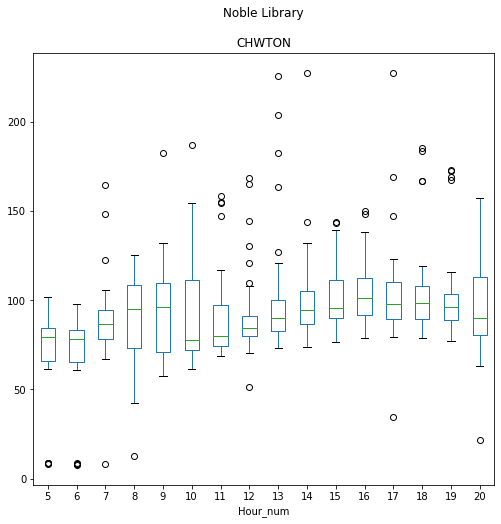

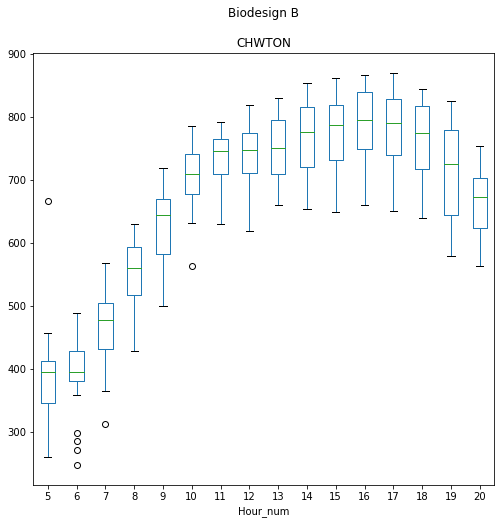

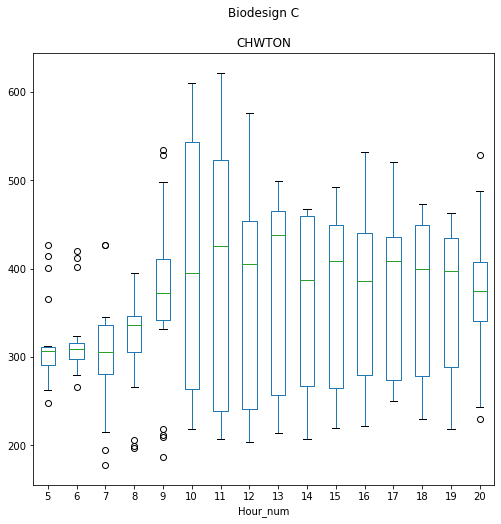

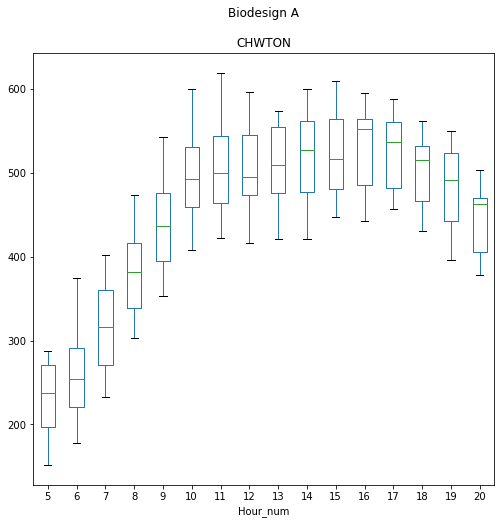

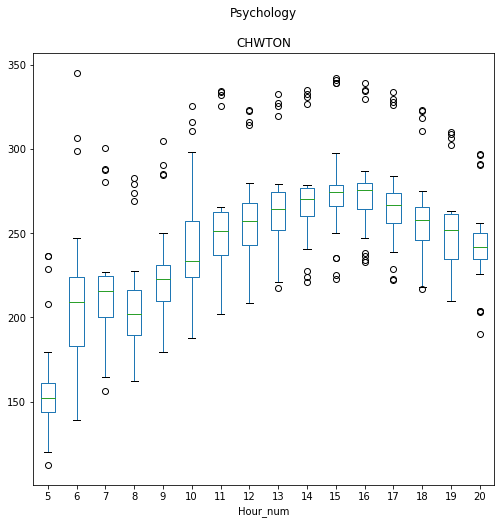

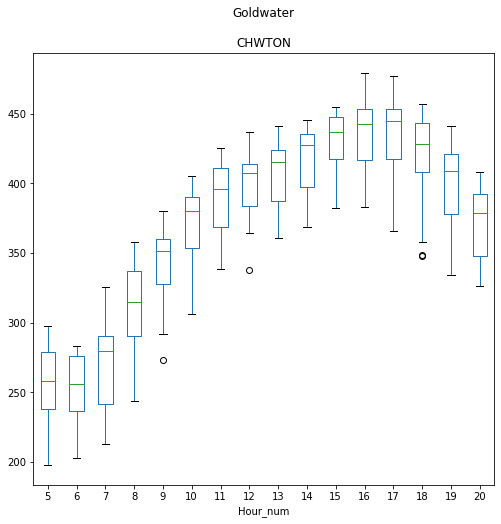

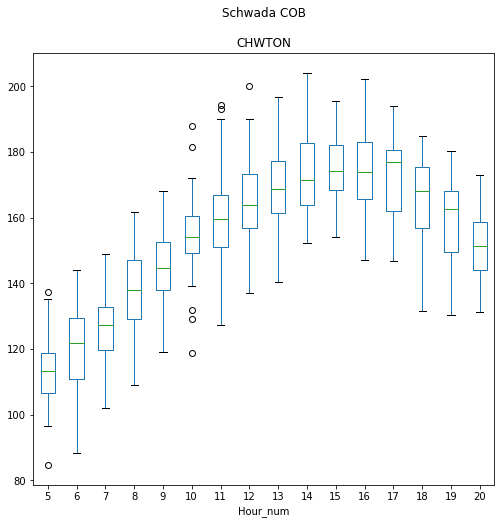

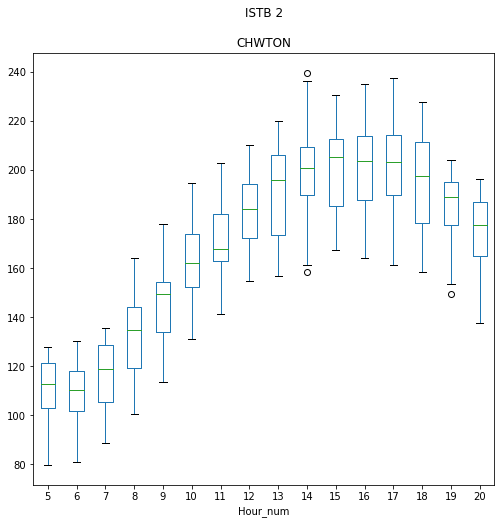

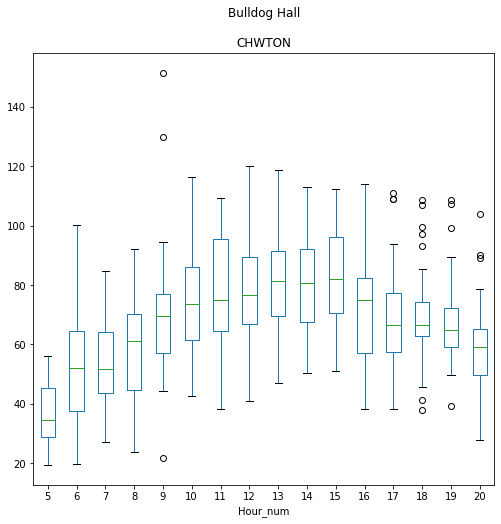

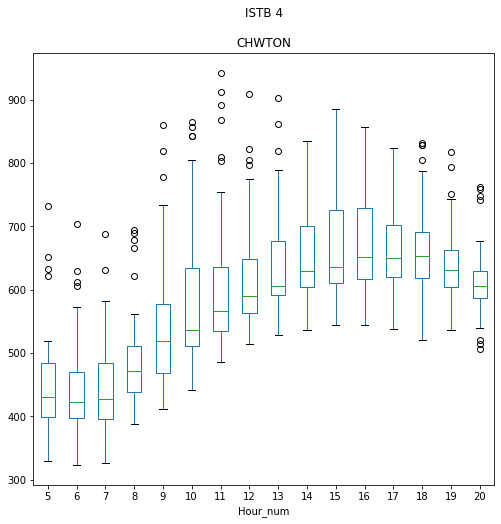

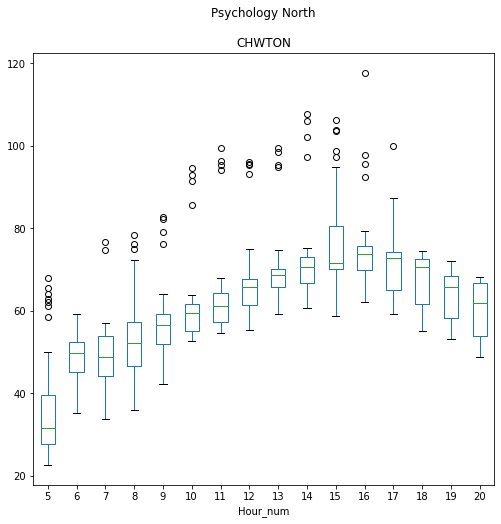

In [13]:
## Print all boxplots for all buildings ##
for i in range(len(Bldg)):
    Bldg[i].boxplot(by='Hour_num', column=['CHWTON'], grid = False, figsize = (8,8))
    plt.suptitle(Bldg[i].bldgname[0])


### 3.1.2 Time Series

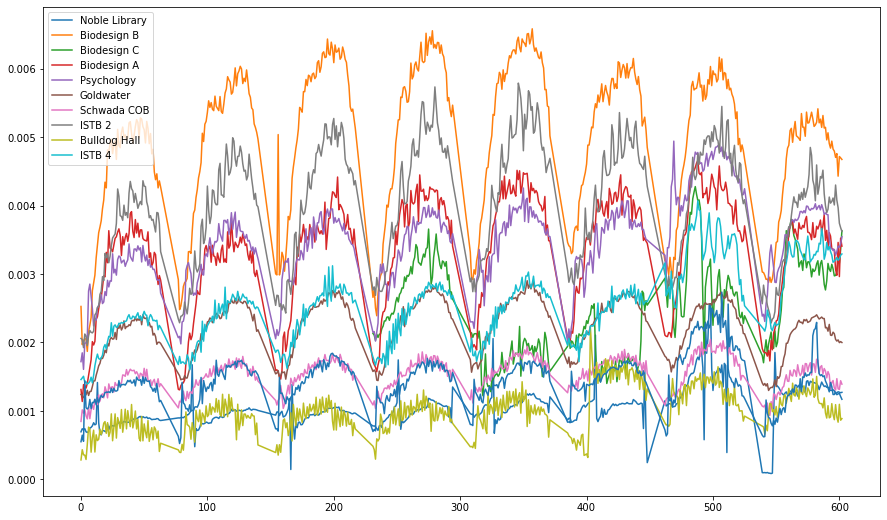

In [14]:
## Print CHWTON/SQFT for all buildings and all timestamps in data
ax = Bldg[0]['CHWTON/SQFT'].plot(figsize = (15,9))
legendlabels = []
for i in range(len(Bldg)-1):
    Bldg[i+1]['CHWTON/SQFT'].plot(ax=ax)
    legendlabels.append(Bldg[i].bldgname[0])
    
ax.legend(labels = legendlabels)


In [ ]:
# Bldg[2]['CHWTON/SQFT'].plot(figsize = (15,9))
# plt.title(Bldg[2].bldgname[0])
# plt.show()

## 3.2 Random Forest without tuning


In [17]:
### Create dataframe and add building names ###
rf_bld_scores = pd.DataFrame(columns = {"bldgname", "test score (on 20% of data)"})
for i in range(len(Bldg)):
    rf_bld_scores = rf_bld_scores.append({'bldgname': Bldg[i]['bldgname'].unique()[0]}, ignore_index=True)
rf_bld_scores.fillna(5)

### Append scores to all buildings ###

for i in range(len(Bldg)):
    
    # drop na values if in dataframe
    if (Bldg[i].isnull().values.any() == True):
        Bldg[i] = Bldg[i].dropna()
        
    # split data into X and y
    X = Bldg[i].drop(columns=['Date', 'Time','bldgname','HTmmBTU', 'Date_Time', 'CHWTON', 'KW', 'CHWTON/SQFT'])
    y = Bldg[i]['CHWTON']
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
    
    # Set up model. Number of trees 100
    base_RF = RandomForestRegressor(n_estimators = 100, random_state = 42)

    # Train data
    base_RF.fit(X_train, y_train)

    # Get prediction
    y_pred = base_RF.predict(X_test)
    ModelPred = pd.DataFrame({'Actual CHWTON':y_test, 'Predicted CHWTON':y_pred})
    ModelPred = ModelPred.sort_index()
    
    # Save scores
    score = base_RF.score(X_test, y_test)
    rf_bld_scores['test score (on 20% of data)'][i] = score
    
rf_bld_scores

,bldgname,test score (on 20% of data)
0,Noble Library,0.720384
1,Biodesign B,0.970804
2,Biodesign C,0.781276
3,Biodesign A,0.939826
4,Psychology,0.915797
5,Goldwater,0.974686
6,Schwada COB,0.906129
7,ISTB 2,0.960235
8,Bulldog Hall,0.647676
9,ISTB 4,0.952127
